In [ ]:
import os
import pandas as pd
import numpy as np

Google Drive directory: /content/drive/MyDrive/AIRI/Datasets


# Basic GBM for a single stock

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from typing import Union, Tuple
import matplotlib.pyplot as plt

class BasicGBMSimulator:
    def __init__(self, log_returns: np.ndarray, original_prices: np.ndarray = None):
        self.log_returns = log_returns
        self.original_prices = original_prices
        self.analyze_historical_properties()

    def analyze_historical_properties(self):
        self.daily_mu = np.mean(self.log_returns)
        self.daily_sigma = np.std(self.log_returns)
        self.mu = self.daily_mu * len(self.log_returns)
        self.sigma = self.daily_sigma * np.sqrt(len(self.log_returns))
        self.skew = stats.skew(self.log_returns)
        self.kurtosis = stats.kurtosis(self.log_returns)
        self.vol_cluster = np.corrcoef(
            np.abs(self.log_returns[1:]),
            np.abs(self.log_returns[:-1])
        )[0, 1]

    def simulate_returns(self,
                        n_days: int,
                        preserve_moments: bool = True
                        ) -> np.ndarray:
        if preserve_moments:
            log_returns = self._generate_johnson_returns(n_days)
        else:
            log_returns = np.random.normal(
                self.daily_mu,
                self.daily_sigma,
                n_days
            )

        if abs(self.vol_cluster) > 0.1:
            log_returns = self._add_volatility_clustering(log_returns)

        return log_returns

    def returns_to_price_path(self, returns: np.ndarray, initial_value: float = 1.0) -> np.ndarray:
        log_prices = np.log(initial_value) + np.cumsum(returns)
        prices = np.exp(log_prices)
        return np.insert(prices, 0, initial_value)

    def _generate_johnson_returns(self, n_days: int) -> np.ndarray:
        johnson_params = stats.johnsonsu.fit(self.log_returns)
        log_returns = stats.johnsonsu.rvs(*johnson_params, size=n_days)
        log_returns = (log_returns - np.mean(log_returns)) / np.std(log_returns)
        log_returns = log_returns * self.daily_sigma + self.daily_mu
        return log_returns

    def _add_volatility_clustering(self, log_returns: np.ndarray) -> np.ndarray:
        abs_returns = np.abs(log_returns)
        for i in range(1, len(log_returns)):
            abs_returns[i] = (
                abs_returns[i] * (1 - self.vol_cluster) +
                abs_returns[i-1] * self.vol_cluster
            )
        return np.sign(log_returns) * abs_returns

    def simulate_multiple_price_paths(self,
                                    n_paths: int,
                                    n_days: int,
                                    initial_value: float = 1.0,
                                    preserve_moments: bool = True
                                    ) -> pd.DataFrame:
        paths = np.zeros((n_days + 1, n_paths))

        for i in range(n_paths):
            returns = self.simulate_returns(n_days, preserve_moments)
            paths[:, i] = self.returns_to_price_path(returns, initial_value)

        return pd.DataFrame(paths, columns=[f'path_{i}' for i in range(n_paths)])

    def plot_simulations(self,
                        n_paths: int,
                        n_days: int,
                        initial_value: float = 1.0,
                        preserve_moments: bool = True):
        paths_df = self.simulate_multiple_price_paths(
            n_paths,
            n_days,
            initial_value,
            preserve_moments
        )

        plt.figure(figsize=(12, 6))

        for i in range(min(50, n_paths)):
            plt.plot(paths_df[f'path_{i}'],
                    alpha=0.1,
                    color='blue')

        mean_path = paths_df.mean(axis=1)
        percentile_5 = paths_df.quantile(0.05, axis=1)
        percentile_95 = paths_df.quantile(0.95, axis=1)

        plt.plot(mean_path,
                'r--',
                label='Mean Path',
                linewidth=2)

        plt.fill_between(paths_df.index,
                        percentile_5,
                        percentile_95,
                        color='gray',
                        alpha=0.2,
                        label='90% Confidence Interval')

        if self.original_prices is not None:
            scale_factor = initial_value / self.original_prices[0]
            scaled_original = self.original_prices * scale_factor

            min_length = min(len(scaled_original), len(paths_df))
            plt.plot(scaled_original[:min_length],
                    'g-',
                    label='Original Path',
                    linewidth=2)

        plt.title('Simulated Price Paths Based on Historical Properties')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

        return paths_df

# Example for synthetic data

Historical Properties:
Daily Drift (μ): -0.000178
Daily Volatility (σ): 0.009673
Annualized Drift: -0.0447
Annualized Volatility: 0.1535


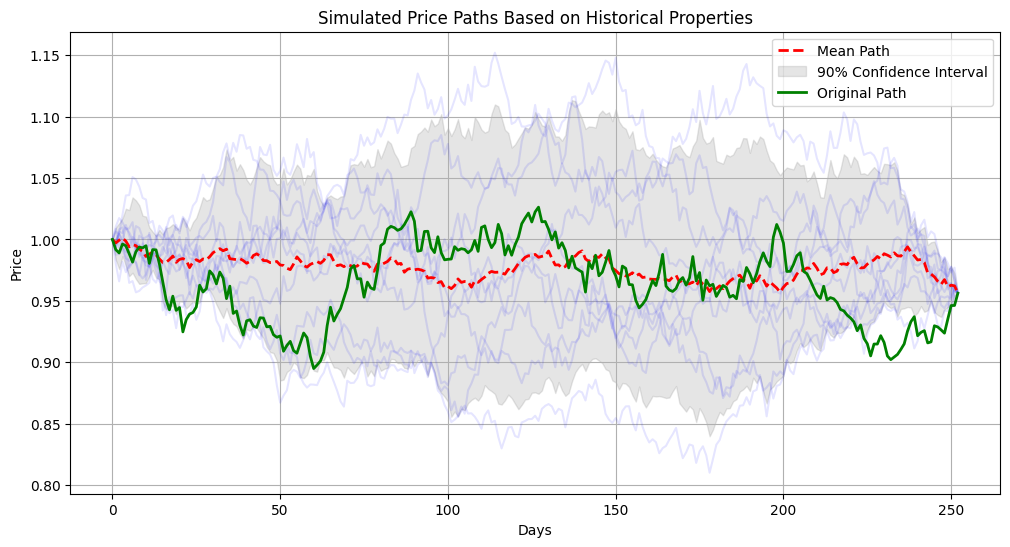

In [3]:
n_days = 252
time = np.arange(n_days + 1)
true_mu = 0.0001
true_sigma = 0.01

original_returns = np.random.normal(true_mu, true_sigma, n_days)
original_prices = np.exp(np.cumsum(np.insert(original_returns, 0, 0)))

simulator = BasicGBMSimulator(original_returns, original_prices)

print("Historical Properties:")
print(f"Daily Drift (μ): {simulator.daily_mu:.6f}")
print(f"Daily Volatility (σ): {simulator.daily_sigma:.6f}")
print(f"Annualized Drift: {simulator.mu:.4f}")
print(f"Annualized Volatility: {simulator.sigma:.4f}")

paths = simulator.plot_simulations(
    n_paths=10,
    n_days=n_days,
    initial_value=1.0,
    preserve_moments=True
)

# Example for a real stock from S&P 500

In [4]:
sp = pd.read_csv('data/sp500_returns.csv')

In [5]:
sp

,Date,MOH,UAL,GOOG,AKAM,AES,MMM,FAST,MCO,MET,...,BIIB,ROP,ALL,TXT,PODD,ECL,LVS,EPAM,AIZ,TT
0,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,NaN,NaN,NaN,-0.068437,-0.040654,-0.040378,-0.056089,-0.028676,NaN,...,-0.069959,-0.046583,-0.032478,-0.016896,NaN,-0.026745,NaN,NaN,NaN,-0.020352
2,2000-01-05,NaN,NaN,NaN,-0.056570,0.010838,0.028127,0.043894,-0.018349,NaN,...,0.067381,-0.013218,0.043331,-0.024072,NaN,0.038093,NaN,NaN,NaN,-0.000935
3,2000-01-06,NaN,NaN,NaN,-0.182872,0.007846,0.077551,0.000000,0.000000,NaN,...,0.043554,0.000000,-0.005412,-0.012809,NaN,0.043470,NaN,NaN,NaN,0.052836
4,2000-01-07,NaN,NaN,NaN,0.050620,0.019149,0.019765,-0.006154,0.024391,NaN,...,0.108752,0.014599,0.036534,0.024019,NaN,0.000000,NaN,NaN,NaN,0.045955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,2024-10-25,0.006008,0.001743,0.014841,-0.008107,-0.001191,-0.013686,0.008208,-0.008906,-0.023553,...,-0.011873,-0.000184,-0.020415,0.010498,-0.016976,-0.011180,0.005343,0.002824,-0.015317,0.000000
6244,2024-10-28,-0.032278,0.019240,0.008052,0.008593,0.005349,0.043446,0.010753,-0.001427,0.008398,...,0.018108,0.005758,0.005777,0.011110,-0.001113,0.011609,0.016233,-0.001202,0.012746,0.000484
6245,2024-10-29,0.024847,0.010979,0.016496,0.001069,-0.031309,-0.007824,0.012186,-0.003555,-0.003035,...,-0.008359,0.006728,-0.014051,-0.018178,-0.004294,-0.010545,-0.004316,0.013449,-0.003507,-0.005540
6246,2024-10-30,0.003275,0.044367,0.028797,-0.010839,-0.006135,-0.013308,0.009362,-0.003350,0.004125,...,-0.012560,-0.002883,0.015266,0.003540,-0.007733,-0.004582,-0.008687,-0.024911,0.007823,-0.039347


In [13]:
data = sp['MMM'].values[1000:2000]

Historical Properties:
Daily Drift (μ): -0.000178
Daily Volatility (σ): 0.009673
Total Drift: -0.0447
Total Volatility: 0.1535


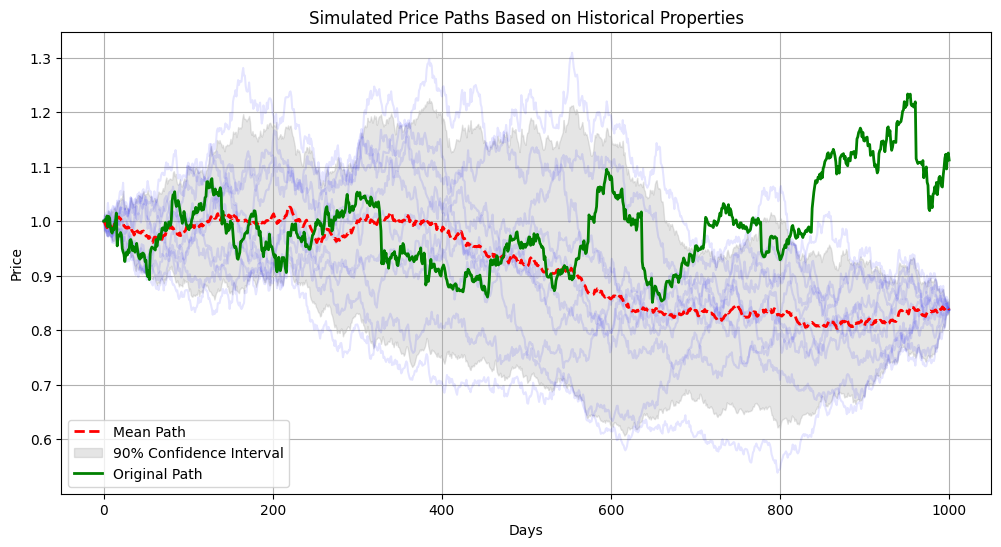

In [14]:
n_days = len(data)
time = np.arange(n_days + 1)
original_prices = np.exp(np.cumsum(np.insert(data, 0, 0)))

simulator = BasicGBMSimulator(original_returns, original_prices)

print("Historical Properties:")
print(f"Daily Drift (μ): {simulator.daily_mu:.6f}")
print(f"Daily Volatility (σ): {simulator.daily_sigma:.6f}")
print(f"Total Drift: {simulator.mu:.4f}")
print(f"Total Volatility: {simulator.sigma:.4f}")

paths = simulator.plot_simulations(
    n_paths=10,
    n_days=n_days,
    initial_value=1.0,
    preserve_moments=True
)